# SRP 2020-2021
## The Role of Income in Hospital Pricing
### Cleaning the data and making histograms
This is the primary setup before I can run my models.

In [2]:
import pandas as pd

hospitals = pd.read_csv('hospital_data.csv')

income = pd.read_csv('income_data.csv')

# dropping any empty values- ZCTAs there is no data on
income = income.dropna(subset=['Estimate_Households_Mean_income'])

# changing the type of the strings in the data frame to integers
income['Estimate_Households_Mean_income'] = income['Estimate_Households_Mean_income'].astype(int)

ztcas = pd.read_csv('ztcas.csv', index_col = 1)

# utilizing the zctas data frame to add a column to the hospitals data frame that converted the zip code the hospital is in the a ZCTA
ztcas_order = []
for i in range(len(hospitals['Hospital name'])):
    zc = hospitals.iloc[i,5]
    ztcas_order.append(ztcas.iloc[(ztcas['ZIP_CODE'].tolist().index(zc)), 0])
hospitals['ZTCA'] = ztcas_order

# calculated the average household income by ZCTA as a percent of the mean household income nationwide and added it as a column in the income data set
mean_income = 92324
percents_of_mean = []
for incom in income['Estimate_Households_Mean_income'].tolist():
    percents_of_mean.append((incom/mean_income)*100)
income['Percent_of_Mean_Household_Income'] = percents_of_mean

Text(0, 0.5, 'Frequency')

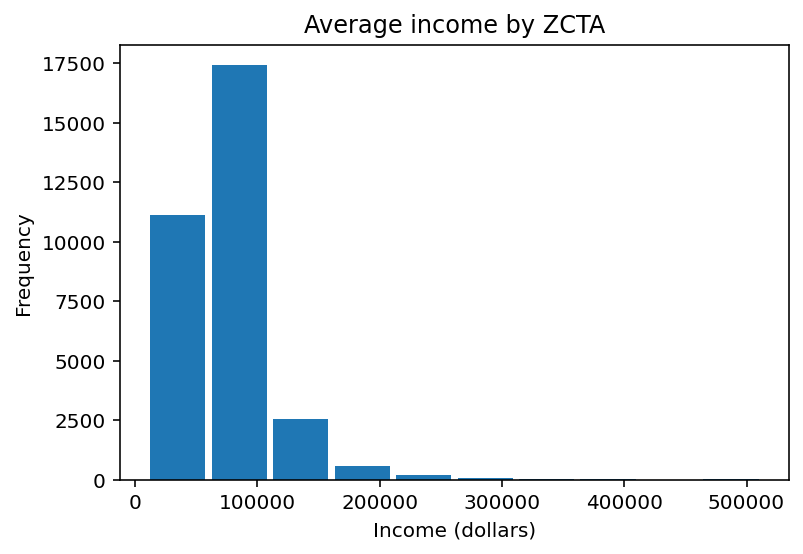

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

incomes = income.Estimate_Households_Mean_income
incomes.plot.hist(rwidth=.9)
plt.title('Average income by ZCTA')
plt.xlabel('Income (dollars)')
plt.ylabel('Frequency')

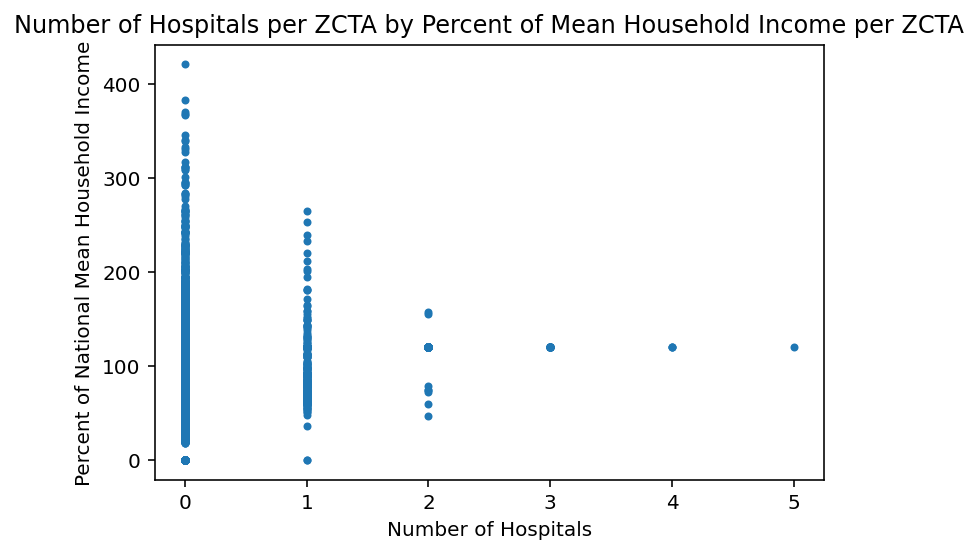

In [4]:
# creating a dataframe where the index is the zip code and the corresponding value in the next column is the ZCTA
zips = pd.read_csv('ztcas.csv')
zips.rename(columns = {'ZIP_CODE':'ZCTA'}, inplace = True)

# replaced any zip codes that don't have ZCTAs so instead of 'No ZCTA' the ZCTA is the zip code
zips_wo_zcta = [96939, 96940, 96941, 96942, 96943, 96944, 96960, 96970]
for i in zips_wo_zcta:
    zips.at[i,'ZCTA'] = i

# created a dictionary of ZCTA : number of hospitals in the ZCTA
hospitals_by_zcta = {}
for zcta in sorted(set(zips['ZCTA'].astype(int).tolist())):
    df = hospitals[hospitals.ZTCA == int(zcta)]
    hospitals_by_zcta[zcta] = len(df)

# created a dictionary of ZCTA : average household income in the ZCTA as a percent of the national average household income
income.rename(columns = {'Geographic Area ame':'Geographic_Area_ame'}, inplace = True)
income_by_zcta = {}
for zcta in sorted(set(zips['ZCTA'].astype(int).tolist())):
    if len(str(zcta)) == 3:
        zcta_str = '00' + str(zcta)
    elif len(str(zcta)) == 4:
        zcta_str = '0' + str(zcta)
    ph = income[income.Geographic_Area_ame == f'ZCTA5 {zcta_str}']
    if len(ph) == 1:
        income_by_zcta[zcta] = ph['Percent_of_Mean_Household_Income'].tolist()[0]
    elif len(ph) > 1:
        income_by_zcta[zcta] = (sum(ph['Percent_of_Mean_Household_Income'].tolist()))/(len(ph['Percent_of_Mean_Household_Income'].tolist()))
    else:
        income_by_zcta[zcta] = 0

# graphing it
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

i = income_by_zcta.values()
h = hospitals_by_zcta.values()
plt.title('Number of Hospitals per ZCTA by Percent of Mean Household Income per ZCTA')
plt.xlabel('Number of Hospitals')
plt.ylabel('Percent of National Mean Household Income')
plt.plot(h, i, '.');

### Making some models
I ran three different types of models each with the same features. I got the best results from the Random Forest model.

In [5]:
from numpy import arange
from sklearn.linear_model import LassoCV
from sklearn.model_selection import RepeatedKFold

# merging dataframes so all the features are in one dataframe (master)
hcris = pd.read_csv('hcris_merged_hospyear_2018.csv')
new = pd.merge(hospitals, hcris, on='pn', how='left')
new_income = pd.read_csv('census_income_clean.csv')
master = pd.merge(new, new_income, on='ZTCA', how='left')

# replacing non-numerical values with numerical values so they can be used for the models
master.Is_hospital_a_critical_access_hospital.replace(('Y', 'N'), (1, 0), inplace=True)

# cleaning the data
master.Median_Household_Income.replace('-', np.nan, inplace=True)
master.Median_Household_Income.replace('N', np.nan, inplace=True)
master.Median_Household_Income.replace('', np.nan, inplace=True)
master.Mean_Household_Income.replace('-', np.nan, inplace=True)
master.Mean_Household_Income.replace('N', np.nan, inplace=True)
master.Mean_Household_Income.replace('', np.nan, inplace=True)

# adding a column of the number of hospitals in the ZCTA for each hospital
tuppies = []
for val in sorted(set(master['ZTCA'].tolist())):
    n = len(master[master.ZTCA == val])
    tuppies.append((val, n))
hospitals_per_zcta = pd.DataFrame(tuppies, columns =['ZTCA', 'number_of_hospitals_in_the_zcta'])
master = pd.merge(master, hospitals_per_zcta, on='ZTCA', how='left')

# adding a column of the total number of hospitals in the ZCTAs withtin 25 miles from the center of the ZCTA each hospital is in
tuppie_dict = dict(tuppies)
dftups = []
zctadist = pd.read_csv('zctadistance.csv')
for val in sorted(set(master['ZTCA'].tolist())):
    temp = zctadist[zctadist.zip1 == val]
    if val in tuppie_dict.keys():
        n = tuppie_dict[val]
    else:
        n = 0
    for v in temp['zip2'].tolist():
        if v in tuppie_dict.keys():
            n += tuppie_dict[v]
    dftups.append((val, n))
zcta_to_zcta = pd.DataFrame(dftups, columns =['ZTCA', 'number_of_hospitals_in_25_miles'])
master = pd.merge(master, zcta_to_zcta, on='ZTCA', how='left')
pop_den = pd.read_csv('pop_den.csv')
master = pd.merge(master, pop_den, on='ZTCA', how='left')

# creating a smaller dataframe containing only the features that get used in the models called master_variables
master_variables = master[['Relative_price_for_outpatient_facility_services', 'Hospital Compare 5-star rating (October 2018, NA=Not Available)', 'Is_hospital_a_critical_access_hospital', 'beds_adultped_wtd', 'Median_Household_Income', 'Mean_Household_Income', 'icu_beds_wtd', 'beds_total_wtd', 'totcost', 'number_of_hospitals_in_the_zcta', 'number_of_hospitals_in_25_miles', 'Population density of ZCTA']]
master_variables = master_variables.dropna()

master_variables['Relative_price_for_outpatient_facility_services'] = master_variables['Relative_price_for_outpatient_facility_services'].str.rstrip('% ').astype('int')


master_variables['Median_Household_Income'] = master_variables['Median_Household_Income'].astype('int')
master_variables['Mean_Household_Income'] = master_variables['Mean_Household_Income'].astype('int')

# finding the 10th-90th percentiles for the mean household income values
print(master_variables.Mean_Household_Income.quantile(0.1))
print(master_variables.Mean_Household_Income.quantile(0.2))
print(master_variables.Mean_Household_Income.quantile(0.3))
print(master_variables.Mean_Household_Income.quantile(0.4))
print(master_variables.Mean_Household_Income.quantile(0.5))
print(master_variables.Mean_Household_Income.quantile(0.6))
print(master_variables.Mean_Household_Income.quantile(0.7))
print(master_variables.Mean_Household_Income.quantile(0.8))
print(master_variables.Mean_Household_Income.quantile(0.9))

52815.2
59558.8
63538.6
67937.6
73069.0
79222.4
87859.99999999999
102686.80000000002
128093.0


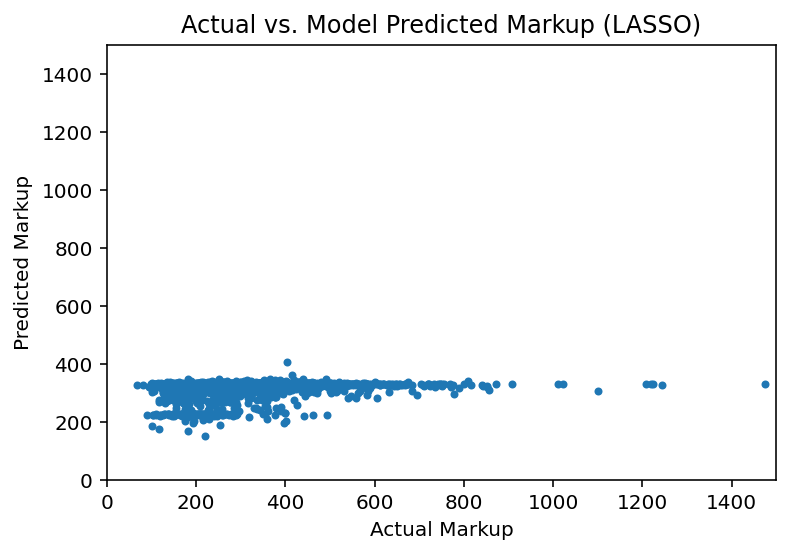

In [6]:
# renaming the variables to be more self-explanatory
master_variables.rename(columns = {'Hospital Compare 5-star rating (October 2018, NA=Not Available)':'Hospital Compare 5-star rating (October 2018)'}, inplace = True)
master_variables.rename(columns = {'Is_hospital_a_critical_access_hospital':'Is hospital a critical access hospital'}, inplace = True)
master_variables.rename(columns = {'beds_adultped_wtd':'Number of beds - adults & peds'}, inplace = True)
master_variables.rename(columns = {'Median_Household_Income':'Median household income'}, inplace = True)
master_variables.rename(columns = {'Mean_Household_Income':'Mean household income'}, inplace = True)
master_variables.rename(columns = {'icu_beds_wtd':'Number of intensive care unit beds'}, inplace = True)
master_variables.rename(columns = {'beds_total_wtd':'Total beds inc swing + spec care beds e.g. icu, ccu, nicu'}, inplace = True)
master_variables.rename(columns = {'totcost':'Total cost (sum of opexp and othexp)'}, inplace = True)
master_variables.rename(columns = {'number_of_hospitals_in_the_zcta':'Total number of hospitals in the zcta'}, inplace = True)
master_variables.rename(columns = {'number_of_hospitals_in_25_miles':'Total number of hospitals within 25 miles'}, inplace = True)
master_variables.rename(columns = {'Relative_price_for_outpatient_facility_services':'Relative price for outpatient facility services'}, inplace = True)

# defining my features (X) and what the model is predicting (y)
X = master_variables[["Hospital Compare 5-star rating (October 2018)", "Is hospital a critical access hospital", "Number of beds - adults & peds", "Median household income", "Mean household income", "Number of intensive care unit beds", "Total beds inc swing + spec care beds e.g. icu, ccu, nicu", "Total cost (sum of opexp and othexp)", 'Total number of hospitals in the zcta', 'Total number of hospitals within 25 miles', 'Population density of ZCTA']]
y = master_variables["Relative price for outpatient facility services"]

# running a LASSO regression model
cv = RepeatedKFold(n_splits=10, n_repeats=30, random_state=1)
l_model = LassoCV(alphas=arange(0.01, 1, 0.01), cv=cv, n_jobs=-1, tol=1)
l_model.fit(X, y)  # fitting the model

l_predictions = []  # creating a list of the predicted values and the real values for comparison
l_real = []
for ind in master_variables.index:
    test = [master_variables['Hospital Compare 5-star rating (October 2018)'][ind], master_variables['Is hospital a critical access hospital'][ind], master_variables['Number of beds - adults & peds'][ind], master_variables['Median household income'][ind], master_variables['Mean household income'][ind], master_variables['Number of intensive care unit beds'][ind], master_variables['Total beds inc swing + spec care beds e.g. icu, ccu, nicu'][ind], master_variables['Total cost (sum of opexp and othexp)'][ind], master_variables['Total number of hospitals in the zcta'][ind], master_variables['Total number of hospitals within 25 miles'][ind], master_variables['Population density of ZCTA'][ind]]
    l_predictions.append(l_model.predict([test])[0])
    l_real.append(master_variables['Relative price for outpatient facility services'][ind])

# graphing the real values vs. predicted values
p = l_predictions
r = l_real
plt.title('Actual vs. Model Predicted Markup (LASSO)')
plt.xlabel('Actual Markup')
plt.ylabel('Predicted Markup')
plt.xlim([0, 1500])
plt.ylim([0, 1500])
plt.plot(r, p, '.');

[ 1.02616917e+00 -1.23276648e+02  1.37972304e-01  1.08172731e-04
 -1.80344330e-04 -2.49085954e-02 -1.37972244e-01  2.76538117e-08
  3.48299626e+00 -1.29852468e+00 -1.06296098e-03]
332.26599093811814


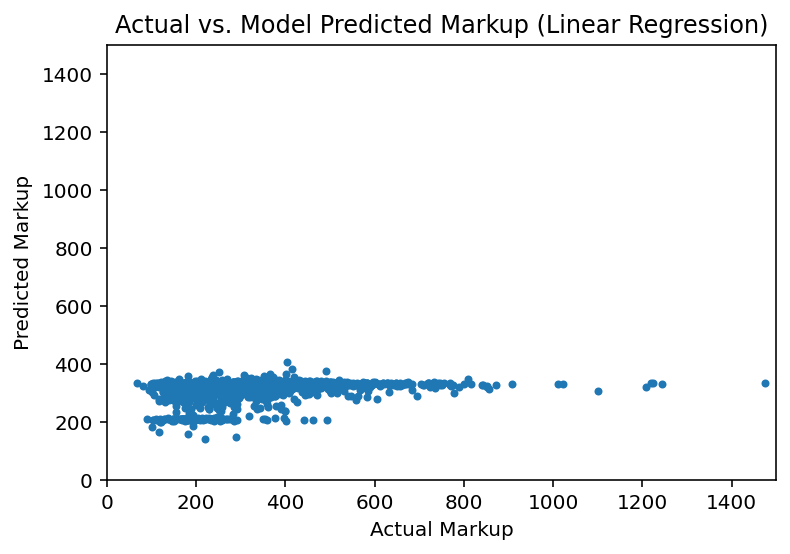

In [7]:
from sklearn.linear_model import LinearRegression

# running a linear regression model
r_model = LinearRegression()
r_model.fit(X, y)
print(r_model.coef_)
print(r_model.intercept_)
r_predictions = []
r_real = []
for ind in master_variables.index:
    test = [master_variables['Hospital Compare 5-star rating (October 2018)'][ind], master_variables['Is hospital a critical access hospital'][ind], master_variables['Number of beds - adults & peds'][ind], master_variables['Median household income'][ind], master_variables['Mean household income'][ind], master_variables['Number of intensive care unit beds'][ind], master_variables['Total beds inc swing + spec care beds e.g. icu, ccu, nicu'][ind], master_variables['Total cost (sum of opexp and othexp)'][ind], master_variables['Total number of hospitals in the zcta'][ind], master_variables['Total number of hospitals within 25 miles'][ind], master_variables['Population density of ZCTA'][ind]]
    r_predictions.append(r_model.predict([test])[0])
    r_real.append(master_variables['Relative price for outpatient facility services'][ind])

p = r_predictions
r = r_real
plt.title('Actual vs. Model Predicted Markup (Linear Regression)')
plt.xlabel('Actual Markup')
plt.ylabel('Predicted Markup')
plt.xlim([0, 1500])
plt.ylim([0, 1500])
plt.plot(r, p, '.');

Mean Absolute Error: 36.69727492314449
Mean Squared Error: 2596.728497046552
Root Mean Squared Error: 50.95810531256585


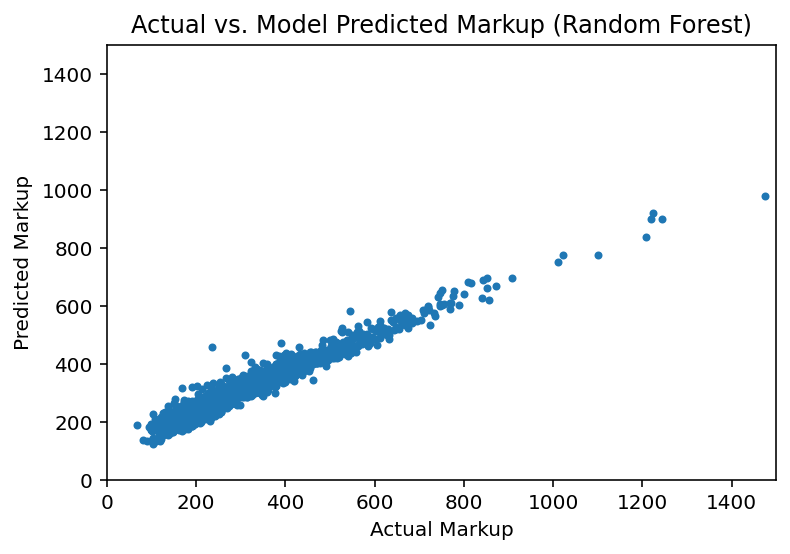

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

# running a Random Forest regression model
regressor = RandomForestRegressor(n_estimators=200, random_state=0)
regressor.fit(X, y)
y_pred = regressor.predict(X)

f_predictions = []
f_real = []
for ind in master_variables.index:
    test = [master_variables['Hospital Compare 5-star rating (October 2018)'][ind], master_variables['Is hospital a critical access hospital'][ind], master_variables['Number of beds - adults & peds'][ind], master_variables['Median household income'][ind], master_variables['Mean household income'][ind], master_variables['Number of intensive care unit beds'][ind], master_variables['Total beds inc swing + spec care beds e.g. icu, ccu, nicu'][ind], master_variables['Total cost (sum of opexp and othexp)'][ind], master_variables['Total number of hospitals in the zcta'][ind], master_variables['Total number of hospitals within 25 miles'][ind], master_variables['Population density of ZCTA'][ind]]
    f_predictions.append(regressor.predict([test])[0])
    f_real.append(master_variables['Relative price for outpatient facility services'][ind])

p = f_predictions
r = f_real
plt.title('Actual vs. Model Predicted Markup (Random Forest)')
plt.xlabel('Actual Markup')
plt.ylabel('Predicted Markup')
plt.xlim([0, 1500])
plt.ylim([0, 1500])

plt.plot(r, p, '.');

print('Mean Absolute Error:', metrics.mean_absolute_error(y, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y, y_pred)))

Text(0.5, 0, 'Random Forest Feature Importance')

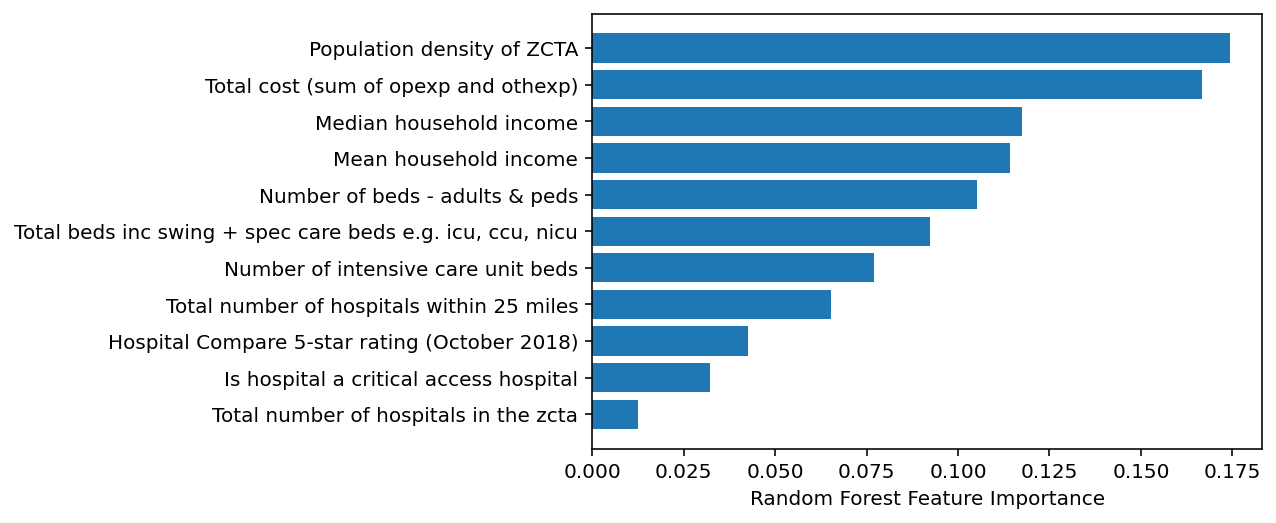

In [9]:
# graphing feature importance according to the Random Forest Model
feature_names = ['Hospital Compare 5-star rating (October 2018)',
       'Is hospital a critical access hospital',
       'Number of beds - adults & peds', 'Median household income',
       'Mean household income', 'Number of intensive care unit beds', 'Total beds inc swing + spec care beds e.g. icu, ccu, nicu',
       'Total cost (sum of opexp and othexp)', 'Total number of hospitals in the zcta', 'Total number of hospitals within 25 miles', 'Population density of ZCTA',
       'Relative price for outpatient facility services']
sorted_idx = regressor.feature_importances_.argsort()
plt.barh(np.array(feature_names)[sorted_idx], np.array(regressor.feature_importances_)[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

349.4534365393061


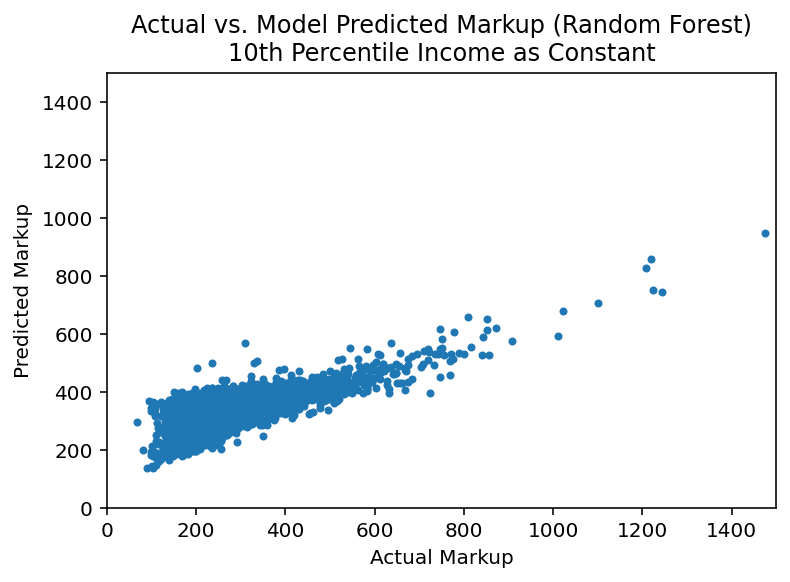

In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

# running a Random Forest regression model with a constant value for mean household income - the 10th percentile value
f1_regressor = RandomForestRegressor(n_estimators=200, random_state=0)
f1_regressor.fit(X, y)
y_pred = f1_regressor.predict(X)

f1_predictions = []
f1_real = []
for ind in master_variables.index:
    test = [master_variables['Hospital Compare 5-star rating (October 2018)'][ind], master_variables['Is hospital a critical access hospital'][ind], master_variables['Number of beds - adults & peds'][ind], master_variables['Median household income'][ind], 52815.2, master_variables['Number of intensive care unit beds'][ind], master_variables['Total beds inc swing + spec care beds e.g. icu, ccu, nicu'][ind], master_variables['Total cost (sum of opexp and othexp)'][ind], master_variables['Total number of hospitals in the zcta'][ind], master_variables['Total number of hospitals within 25 miles'][ind], master_variables['Population density of ZCTA'][ind]]
    f1_predictions.append(f1_regressor.predict([test])[0])
    f1_real.append(master_variables['Relative price for outpatient facility services'][ind])

p = f1_predictions
r = f1_real
plt.title('Actual vs. Model Predicted Markup (Random Forest)\n10th Percentile Income as Constant')
plt.xlabel('Actual Markup')
plt.ylabel('Predicted Markup')
plt.xlim([0, 1500])
plt.ylim([0, 1500])

plt.plot(r, p, '.');

print(np.average(f1_predictions))

351.1093763724199


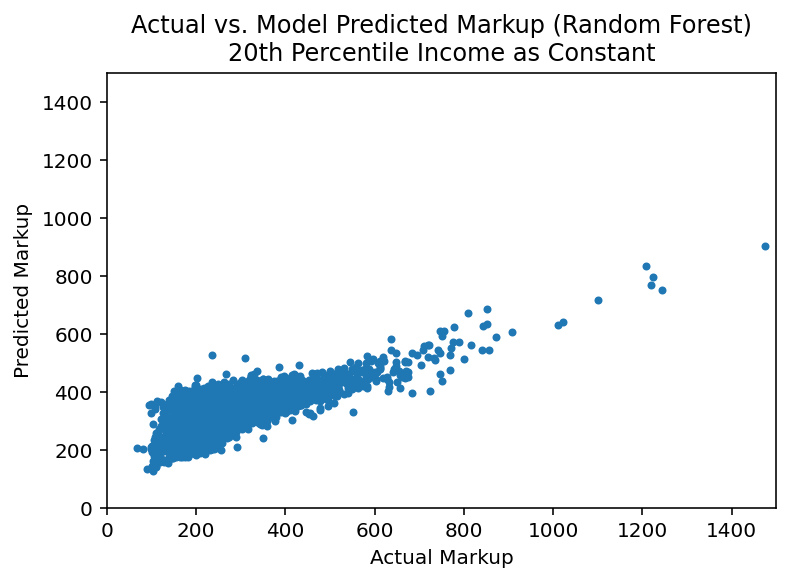

In [20]:
f2_regressor = RandomForestRegressor(n_estimators=200, random_state=0)
f2_regressor.fit(X, y)
y_pred = f2_regressor.predict(X)

# running a Random Forest regression model with a constant value for mean household income - the 20th percentile value
f2_predictions = []
f2_real = []
for ind in master_variables.index:
    test = [master_variables['Hospital Compare 5-star rating (October 2018)'][ind], master_variables['Is hospital a critical access hospital'][ind], master_variables['Number of beds - adults & peds'][ind], master_variables['Median household income'][ind], 59558.8, master_variables['Number of intensive care unit beds'][ind], master_variables['Total beds inc swing + spec care beds e.g. icu, ccu, nicu'][ind], master_variables['Total cost (sum of opexp and othexp)'][ind], master_variables['Total number of hospitals in the zcta'][ind], master_variables['Total number of hospitals within 25 miles'][ind], master_variables['Population density of ZCTA'][ind]]
    f2_predictions.append(f2_regressor.predict([test])[0])
    f2_real.append(master_variables['Relative price for outpatient facility services'][ind])

p = f2_predictions
r = f2_real
plt.title('Actual vs. Model Predicted Markup (Random Forest)\n20th Percentile Income as Constant')
plt.xlabel('Actual Markup')
plt.ylabel('Predicted Markup')
plt.xlim([0, 1500])
plt.ylim([0, 1500])

plt.plot(r, p, '.');

print(np.average(f2_predictions))

338.21015590689507


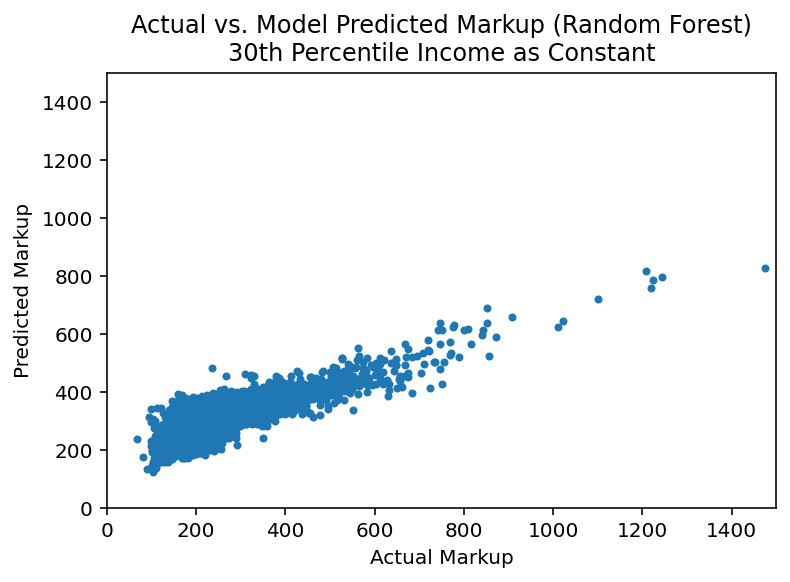

In [22]:
f3_regressor = RandomForestRegressor(n_estimators=200, random_state=0)
f3_regressor.fit(X, y)
y_pred = f3_regressor.predict(X)

# running a Random Forest regression model with a constant value for mean household income - the 30th percentile value
f3_predictions = []
f3_real = []
for ind in master_variables.index:
    test = [master_variables['Hospital Compare 5-star rating (October 2018)'][ind], master_variables['Is hospital a critical access hospital'][ind], master_variables['Number of beds - adults & peds'][ind], master_variables['Median household income'][ind], 63538.6, master_variables['Number of intensive care unit beds'][ind], master_variables['Total beds inc swing + spec care beds e.g. icu, ccu, nicu'][ind], master_variables['Total cost (sum of opexp and othexp)'][ind], master_variables['Total number of hospitals in the zcta'][ind], master_variables['Total number of hospitals within 25 miles'][ind], master_variables['Population density of ZCTA'][ind]]
    f3_predictions.append(f3_regressor.predict([test])[0])
    f3_real.append(master_variables['Relative price for outpatient facility services'][ind])

p = f3_predictions
r = f3_real
plt.title('Actual vs. Model Predicted Markup (Random Forest)\n30th Percentile Income as Constant')
plt.xlabel('Actual Markup')
plt.ylabel('Predicted Markup')
plt.xlim([0, 1500])
plt.ylim([0, 1500])

plt.plot(r, p, '.');

print(np.average(f3_predictions))

325.9318533157663


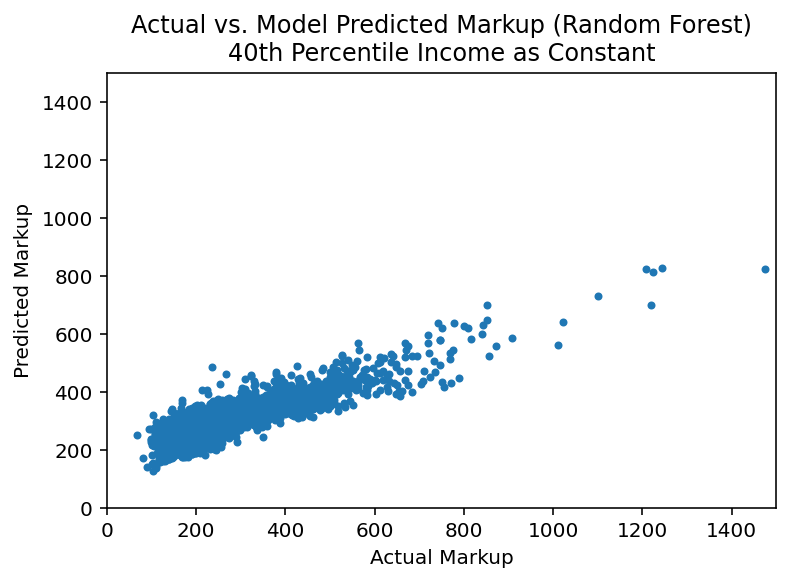

In [23]:
f4_regressor = RandomForestRegressor(n_estimators=200, random_state=0)
f4_regressor.fit(X, y)
y_pred = f4_regressor.predict(X)

# running a Random Forest regression model with a constant value for mean household income - the 40th percentile value
f4_predictions = []
f4_real = []
for ind in master_variables.index:
    test = [master_variables['Hospital Compare 5-star rating (October 2018)'][ind], master_variables['Is hospital a critical access hospital'][ind], master_variables['Number of beds - adults & peds'][ind], master_variables['Median household income'][ind], 67937.6, master_variables['Number of intensive care unit beds'][ind], master_variables['Total beds inc swing + spec care beds e.g. icu, ccu, nicu'][ind], master_variables['Total cost (sum of opexp and othexp)'][ind], master_variables['Total number of hospitals in the zcta'][ind], master_variables['Total number of hospitals within 25 miles'][ind], master_variables['Population density of ZCTA'][ind]]
    f4_predictions.append(f4_regressor.predict([test])[0])
    f4_real.append(master_variables['Relative price for outpatient facility services'][ind])

p = f4_predictions
r = f4_real
plt.title('Actual vs. Model Predicted Markup (Random Forest)\n40th Percentile Income as Constant')
plt.xlabel('Actual Markup')
plt.ylabel('Predicted Markup')
plt.xlim([0, 1500])
plt.ylim([0, 1500])

plt.plot(r, p, '.');

print(np.average(f4_predictions))

330.65347606499785


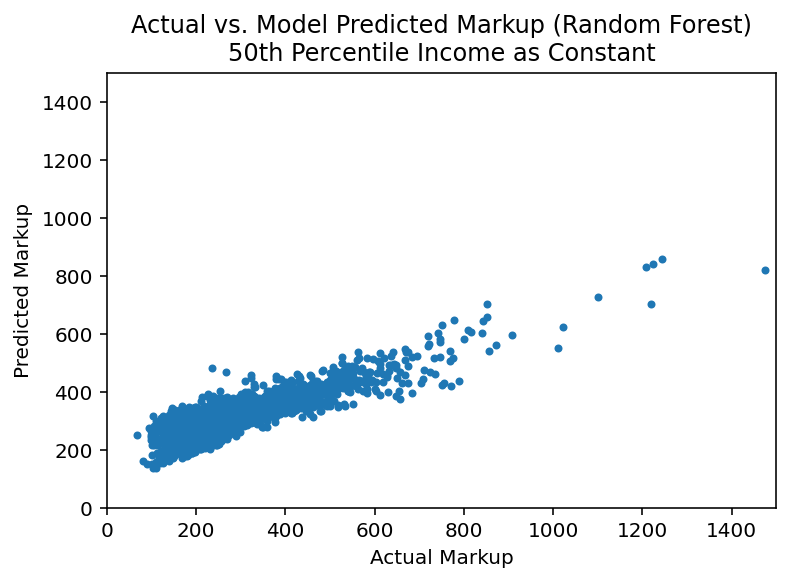

In [28]:
f5_regressor = RandomForestRegressor(n_estimators=200, random_state=0)
f5_regressor.fit(X, y)
y_pred = f5_regressor.predict(X)

# running a Random Forest regression model with a constant value for mean household income - the 50th percentile value
f5_predictions = []
f5_real = []
for ind in master_variables.index:
    test = [master_variables['Hospital Compare 5-star rating (October 2018)'][ind], master_variables['Is hospital a critical access hospital'][ind], master_variables['Number of beds - adults & peds'][ind], master_variables['Median household income'][ind], 73069.0, master_variables['Number of intensive care unit beds'][ind], master_variables['Total beds inc swing + spec care beds e.g. icu, ccu, nicu'][ind], master_variables['Total cost (sum of opexp and othexp)'][ind], master_variables['Total number of hospitals in the zcta'][ind], master_variables['Total number of hospitals within 25 miles'][ind], master_variables['Population density of ZCTA'][ind]]
    f5_predictions.append(f5_regressor.predict([test])[0])
    f5_real.append(master_variables['Relative price for outpatient facility services'][ind])

p = f5_predictions
r = f5_real
plt.title('Actual vs. Model Predicted Markup (Random Forest)\n50th Percentile Income as Constant')
plt.xlabel('Actual Markup')
plt.ylabel('Predicted Markup')
plt.xlim([0, 1500])
plt.ylim([0, 1500])

plt.plot(r, p, '.');

print(np.average(f5_predictions))

324.41933465085634


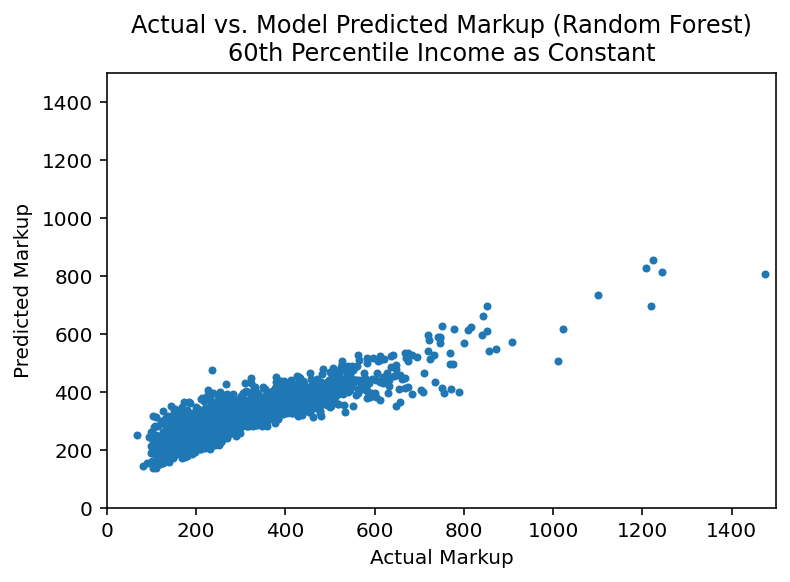

In [29]:
f6_regressor = RandomForestRegressor(n_estimators=200, random_state=0)
f6_regressor.fit(X, y)
y_pred = f6_regressor.predict(X)

# running a Random Forest regression model with a constant value for mean household income - the 60th percentile value
f6_predictions = []
f6_real = []
for ind in master_variables.index:
    test = [master_variables['Hospital Compare 5-star rating (October 2018)'][ind], master_variables['Is hospital a critical access hospital'][ind], master_variables['Number of beds - adults & peds'][ind], master_variables['Median household income'][ind], 79222.4, master_variables['Number of intensive care unit beds'][ind], master_variables['Total beds inc swing + spec care beds e.g. icu, ccu, nicu'][ind], master_variables['Total cost (sum of opexp and othexp)'][ind], master_variables['Total number of hospitals in the zcta'][ind], master_variables['Total number of hospitals within 25 miles'][ind], master_variables['Population density of ZCTA'][ind]]
    f6_predictions.append(f6_regressor.predict([test])[0])
    f6_real.append(master_variables['Relative price for outpatient facility services'][ind])

p = f6_predictions
r = f6_real
plt.title('Actual vs. Model Predicted Markup (Random Forest)\n60th Percentile Income as Constant')
plt.xlabel('Actual Markup')
plt.ylabel('Predicted Markup')
plt.xlim([0, 1500])
plt.ylim([0, 1500])

plt.plot(r, p, '.');

print(np.average(f6_predictions))

328.6899890206412


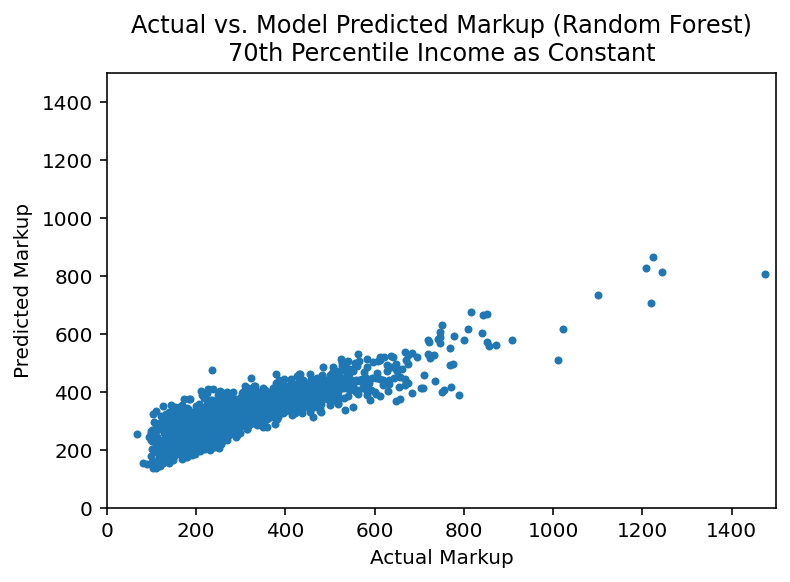

In [30]:
f7_regressor = RandomForestRegressor(n_estimators=200, random_state=0)
f7_regressor.fit(X, y)
y_pred = f7_regressor.predict(X)

# running a Random Forest regression model with a constant value for mean household income - the 70th percentile value
f7_predictions = []
f7_real = []
for ind in master_variables.index:
    test = [master_variables['Hospital Compare 5-star rating (October 2018)'][ind], master_variables['Is hospital a critical access hospital'][ind], master_variables['Number of beds - adults & peds'][ind], master_variables['Median household income'][ind], 87859.99999999999, master_variables['Number of intensive care unit beds'][ind], master_variables['Total beds inc swing + spec care beds e.g. icu, ccu, nicu'][ind], master_variables['Total cost (sum of opexp and othexp)'][ind], master_variables['Total number of hospitals in the zcta'][ind], master_variables['Total number of hospitals within 25 miles'][ind], master_variables['Population density of ZCTA'][ind]]
    f7_predictions.append(f7_regressor.predict([test])[0])
    f7_real.append(master_variables['Relative price for outpatient facility services'][ind])

p = f7_predictions
r = f7_real
plt.title('Actual vs. Model Predicted Markup (Random Forest)\n70th Percentile Income as Constant')
plt.xlabel('Actual Markup')
plt.ylabel('Predicted Markup')
plt.xlim([0, 1500])
plt.ylim([0, 1500])

plt.plot(r, p, '.');

print(np.average(f7_predictions))

323.4854369784805


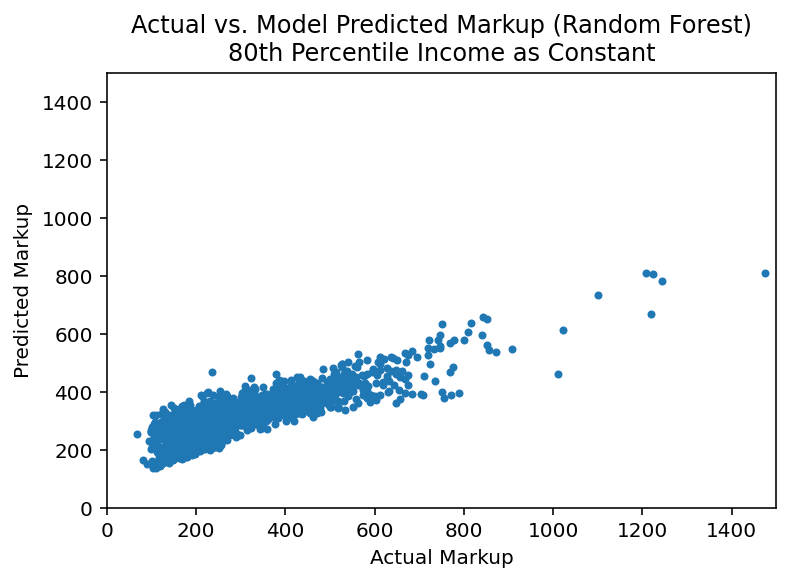

In [31]:
f8_regressor = RandomForestRegressor(n_estimators=200, random_state=0)
f8_regressor.fit(X, y)
y_pred = f8_regressor.predict(X)

# running a Random Forest regression model with a constant value for mean household income - the 80th percentile value
f8_predictions = []
f8_real = []
for ind in master_variables.index:
    test = [master_variables['Hospital Compare 5-star rating (October 2018)'][ind], master_variables['Is hospital a critical access hospital'][ind], master_variables['Number of beds - adults & peds'][ind], master_variables['Median household income'][ind], 102686.80000000002, master_variables['Number of intensive care unit beds'][ind], master_variables['Total beds inc swing + spec care beds e.g. icu, ccu, nicu'][ind], master_variables['Total cost (sum of opexp and othexp)'][ind], master_variables['Total number of hospitals in the zcta'][ind], master_variables['Total number of hospitals within 25 miles'][ind], master_variables['Population density of ZCTA'][ind]]
    f8_predictions.append(f8_regressor.predict([test])[0])
    f8_real.append(master_variables['Relative price for outpatient facility services'][ind])

p = f8_predictions
r = f8_real
plt.title('Actual vs. Model Predicted Markup (Random Forest)\n80th Percentile Income as Constant')
plt.xlabel('Actual Markup')
plt.ylabel('Predicted Markup')
plt.xlim([0, 1500])
plt.ylim([0, 1500])

plt.plot(r, p, '.');

print(np.average(f8_predictions))

319.9936012296882


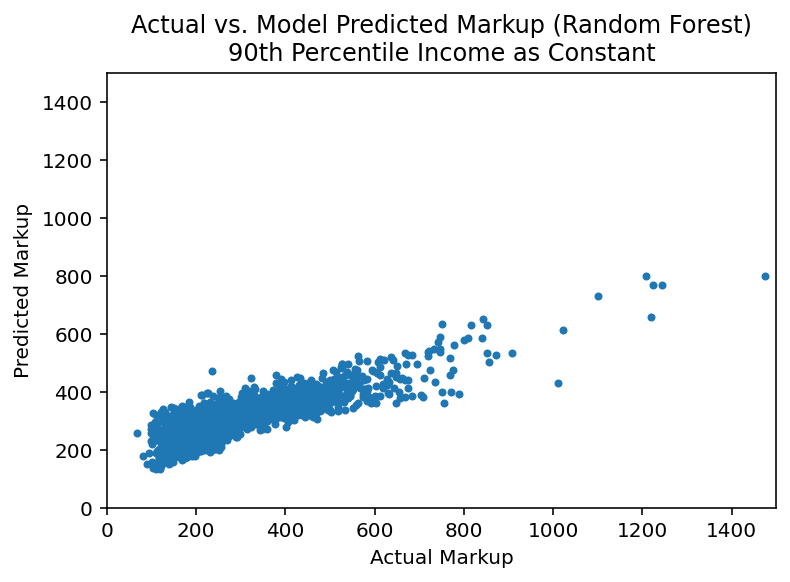

In [32]:
f9_regressor = RandomForestRegressor(n_estimators=200, random_state=0)
f9_regressor.fit(X, y)
y_pred = f9_regressor.predict(X)

# running a Random Forest regression model with a constant value for mean household income - the 90th percentile value
f9_predictions = []
f9_real = []
for ind in master_variables.index:
    test = [master_variables['Hospital Compare 5-star rating (October 2018)'][ind], master_variables['Is hospital a critical access hospital'][ind], master_variables['Number of beds - adults & peds'][ind], master_variables['Median household income'][ind], 128093.0, master_variables['Number of intensive care unit beds'][ind], master_variables['Total beds inc swing + spec care beds e.g. icu, ccu, nicu'][ind], master_variables['Total cost (sum of opexp and othexp)'][ind], master_variables['Total number of hospitals in the zcta'][ind], master_variables['Total number of hospitals within 25 miles'][ind], master_variables['Population density of ZCTA'][ind]]
    f9_predictions.append(f9_regressor.predict([test])[0])
    f9_real.append(master_variables['Relative price for outpatient facility services'][ind])

p = f9_predictions
r = f9_real
plt.title('Actual vs. Model Predicted Markup (Random Forest)\n90th Percentile Income as Constant')
plt.xlabel('Actual Markup')
plt.ylabel('Predicted Markup')
plt.xlim([0, 1500])
plt.ylim([0, 1500])

plt.plot(r, p, '.');

print(np.average(f9_predictions))

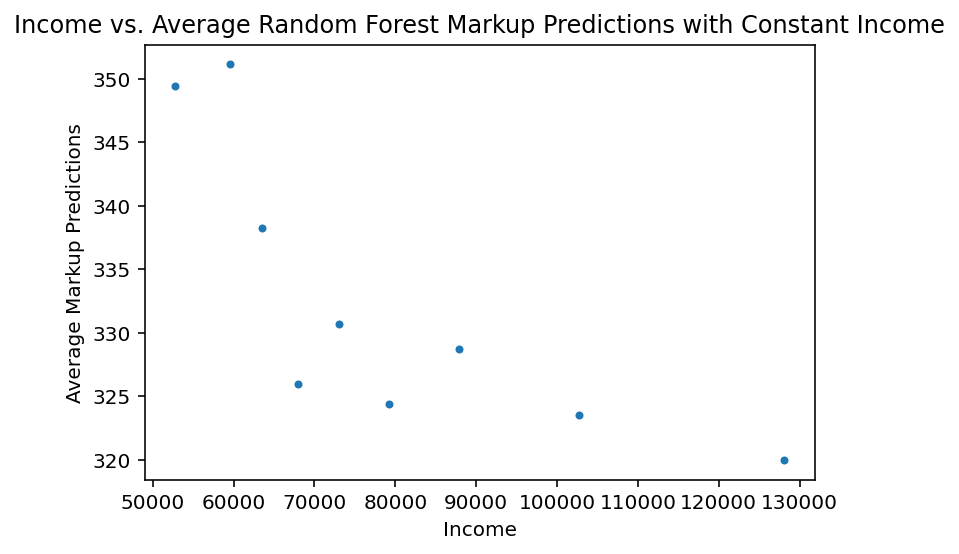

In [33]:
# graphing the mean household income percentiles vs. the average markup prediction from the random forest model with that percentile value as its constant
percentile_income = [52815.2, 59558.8, 63538.6, 67937.6, 73069.0, 79222.4, 87859.99999999999, 102686.80000000002, 128093.0]
predictions_w_constant = [349.4534365393061, 351.1093763724199, 338.21015590689507, 325.9318533157663, 330.65347606499785, 324.41933465085634, 328.6899890206412, 323.4854369784805, 319.9936012296882]

plt.title('Income vs. Average Random Forest Markup Predictions with Constant Income')
plt.xlabel('Income')
plt.ylabel('Average Markup Predictions')

plt.plot(percentile_income, predictions_w_constant, '.');